## We need to find set of REs that:
1. one of the REs must cut human mtDNA only one time
2. other REs must not cut mtDNA but must cut nuclear DNA to pieces less than 3-5kb

In [1]:
import re
import os
import random
import glob
from collections import Counter
from multiprocessing import Pool
from typing import Dict, List, Any
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
from Bio.Restriction import Analysis, AllEnzymes, RestrictionBatch
from Bio.Restriction.Restriction import RestrictionType
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
PIECES_SIZE = 5000
PATH_TO_HUMAN_GENOME = "../data/external/GCF_000001405.40/ncbi_dataset/data/GCF_000001405.40/*.fna"
# PATH_TO_RE = "../data/processed/cuted_seqs_num.csv"
PATH_TO_REF_MT = "../data/external/NC_012920.1.fasta"
PATH_TO_SEQS_MT = "../data/raw/sequence.fasta"
PATH_TO_sibenzyme = "../data/external/sibenzyme.csv"

In [3]:
len(AllEnzymes)

978

In [6]:
# human_genome = SeqIO.parse(PATH_TO_HUMAN_GENOME, "fasta")
mt_seqs = SeqIO.parse(PATH_TO_SEQS_MT, "fasta")
ref_mt = next(SeqIO.parse(PATH_TO_REF_MT, "fasta"))
sibenzyme = pd.read_csv(PATH_TO_sibenzyme)
sibenzyme["RE"] = sibenzyme["RE"].str.replace(" ", "")

### Prepare table with description of REs

In [33]:
sibenzyme.head()

,RE,ID,Site,Packaging,Variant
0,AatII,E287,GACGT↑C / C↓TGCAG,250 е.а. 2500 е.а. 500 е.а.,mini Regular
1,AbsI,E535_,CC↑TCGAGG / GGAGCT↓CC,1000 е.а. 200 е.а.,Regular
2,Acc16I,E001,TGC↑GCA / ACG↓CGT,1000 е.а. 200 е.а.,Regular
3,Acc36I,E289,ACCTGC(N)4↑ / TGGACG(N)8↓,100 е.а. 500 е.а.,Regular
4,Acc65I,E003,G↑GTACC / CCATG↓G,1000 е.а. 500 е.а. 5000 е.а.,mini Regular Turbo


In [32]:
n = 0
for enz in sibenzyme["RE"].unique():
    try:
        x = AllEnzymes.get(enz)
        n += 1
    except:
        print(enz)
print(n)

# KroNI site lay in mt refseq => can't be used

KroNI
195


## Search the enzymes that don't cut mtDNA

In [5]:
def extract_RE_without_site_on_mt(rec: SeqRecord) -> List[Dict]:
    ana = Analysis(AllEnzymes, rec.seq, linear=False)
    data = []
    for restr_enz in ana.without_site():
        re_name = repr(restr_enz)
        one_data = {"RE": re_name, "SeqName": rec.description}
        data.append(one_data)
    return data

In [7]:
# 27 min and 10GB of RAM
threads = 24
with Pool(threads) as p:
    collection_of_pot_rs = p.map(extract_RE_without_site_on_mt, mt_seqs)

In [11]:
pot_rs = []
for xx in collection_of_pot_rs:
    for x in xx:
        pot_rs.append(x)

re_without_site = pd.DataFrame(pot_rs)
re_without_site.to_csv("../data/interim/re_without_site.csv", index=None)
re_without_site.head()

,RE,SeqName
0,ArsI,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...
1,BglII,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...
2,FspI,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...
3,PspOMII,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...
4,MteI,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...


In [16]:
re_maximal_subset = re_without_site.RE.value_counts().reset_index()
re_maximal_subset.columns = ["RE", "NotCuttedSeqsNum"]
re_maximal_subset["Percentage"] = re_maximal_subset.NotCuttedSeqsNum / len(collection_of_pot_rs) * 100
re_maximal_subset.to_csv("../data/processed/NotCuttedSeqsNum.csv", index=None)
re_maximal_subset.head()

,RE,NotCuttedSeqsNum,Percentage
0,Sse232I,56445,100.0
1,SwaI,56445,100.0
2,Sse8387I,56445,100.0
3,MreI,56445,100.0
4,MauBI,56445,100.0


## Search of minimal subset of REs that destroy muclear DNA

1. initially need to add to the set ClaI, as RE that cut mtDNA only one time
2. drop RE dublicates
3. apply approach from GO hw2

In [34]:
re_maximal_subset = pd.read_csv("../data/processed/NotCuttedSeqsNum.csv")
re_maximal_subset

,RE,NotCuttedSeqsNum,Percentage
0,Sse232I,56445,100.000000
1,SwaI,56445,100.000000
2,Sse8387I,56445,100.000000
3,MreI,56445,100.000000
4,MauBI,56445,100.000000
...,...,...,...
255,Cma23826I,1,0.001772
256,Acc65V,1,0.001772
257,PpiP13II,1,0.001772
258,Sse8647I,1,0.001772


In [35]:
def collect_isoschizomers(enzymes: RestrictionBatch) -> List[List[str]]:
    """Search and collect all isoschizomers in passed enzymes"""
    data = []
    visited = set()
    for RE in enzymes:
        if repr(RE) in visited:
            continue

        visited.add(repr(RE))
        isosh_names = []
        for isosh in RE.isoschizomers():
            visited.add(repr(isosh))
            isosh_names.append(repr(isosh))
        data.append([repr(RE)] + isosh_names)
    return data


# # collect full collection of isoschizomers
# full_isosh = collect_isoschizomers(AllEnzymes)
# with open("../data/processed/full_isoschizomers.txt", "w") as fout:
#     for batch in full_isosh:
#         fout.write(",".join(batch) + "\n")

In [62]:
# sample RE that don't cut most of mtDNA
cutoff = 99.5 # %
REs_without_site_on_mt = re_maximal_subset[
    (re_maximal_subset.Percentage > cutoff)].RE.values
print(REs_without_site_on_mt.shape)

# create sample batch (custom data structure)
ClaI = AllEnzymes.get("ClaI")
excess_maximal_subset = RestrictionBatch(list(REs_without_site_on_mt) + ["ClaI"])
excess_maximal_subset

(78,)


RestrictionBatch(['AbsI', 'AcvI', 'AdeI', 'AgeI', 'ArsI', 'AscI', 'AsiGI', 'AsiSI', 'AspJHL3II', 'BbrPI', 'BoxI', 'BsePI', 'BshTI', 'Bsp460III', 'Bsp68I', 'BspGI', 'BssHII', 'BstPAI', 'BtuMI', 'CciNI', 'Cfr9I', 'ClaI', 'CpoI', 'CspAI', 'CspI', 'DraIII', 'Ecl35734I', 'Eco72I', 'FseI', 'FspAI', 'GauT27I', 'Lmo370I', 'MauBI', 'McaTI', 'MluI', 'MreI', 'MspSC27II', 'MteI', 'NotI', 'NpeUS61II', 'NruI', 'PalAI', 'PauI', 'PinAI', 'Ple19I', 'PmaCI', 'PmlI', 'PshAI', 'PspCI', 'PspXI', 'Pst273I', 'PteI', 'PvuI', 'RgaI', 'RigI', 'RpaB5I', 'RruI', 'Rsr2I', 'RsrII', 'SbfI', 'SdaI', 'SfaAI', 'SfiI', 'SgfI', 'SgrDI', 'SgsI', 'SmaI', 'SmiI', 'SrfI', 'Sse232I', 'Sse8387I', 'Ssp714II', 'SstE37I', 'Sth20745III', 'SwaI', 'TspARh3I', 'TspMI', 'UbaF13I', 'XmaI'])

In [63]:
# collect collection of isoschizomers for used sample REs
sufficient_sample = []
full_isosh = collect_isoschizomers(excess_maximal_subset)
with open(f"../data/processed/used_re_isoschizomers_{cutoff}%.txt", "w") as fout:
    for batch in full_isosh:
        sufficient_sample.append(batch[0])
        fout.write(",".join(batch) + "\n")

print(len(sufficient_sample))
maximal_subset = RestrictionBatch(sufficient_sample)
maximal_subset

42


RestrictionBatch(['AbsI', 'AcvI', 'AgeI', 'ArsI', 'AsiSI', 'AspJHL3II', 'Bsp460III', 'BspGI', 'BstPAI', 'CciNI', 'Cfr9I', 'ClaI', 'CspI', 'DraIII', 'Ecl35734I', 'FseI', 'FspAI', 'GauT27I', 'Lmo370I', 'MauBI', 'MluI', 'MreI', 'MspSC27II', 'MteI', 'NpeUS61II', 'PalAI', 'PauI', 'PspXI', 'Pst273I', 'PvuI', 'RpaB5I', 'RruI', 'SfiI', 'SgrDI', 'SmiI', 'SrfI', 'Sse8387I', 'Ssp714II', 'SstE37I', 'Sth20745III', 'TspARh3I', 'UbaF13I'])

In [38]:
def collect_cutpos(record: SeqRecord) -> List[Dict[str, Any]]:
    seq_str = str(record.seq)
    ana = Analysis(maximal_subset, record.seq)
    data_cutpos = []
    for enzyme, positions in ana.with_sites().items():
        for pos in positions:
            data_cutpos.append({
                "Record": record.description,
                "Pos": pos,
                "RE": repr(enzyme), 
            })
    return data_cutpos


# def extract_intervals_from_one_seq(rec_cutpos_df, seq: str):
    # assert rec_cutpos_df.Record.nunique() == 1
    # name = rec_cutpos_df.Record.values[0]
    
def extract_intervals_from_one_record(record: SeqRecord, cutpos: pd.DataFrame):
    data_intervals = []
    seq = str(record.seq)
    name = record.description
    rec_cutpos_df = cutpos[cutpos["Record"] == record.description]
    rec_cutpos_df.sort_values("Pos", inplace=True)
    rec_cutpos_df.reset_index(drop=True, inplace=True)
    
    if rec_cutpos_df.shape[0] == 0:
        Ncount = seq.count("N")
        data_intervals.append({
            "Record": name,
            "Begin": 0,
            "End": len(seq),
            "Lenght": len(seq),
            "Ncount": Ncount,
        })
        return data_intervals

    beg = 0
    prev_RE = None
    for i, row in rec_cutpos_df.iterrows():
        end = row.Pos
        interval = seq[beg: end]
        Ncount = interval.count("N") if len(interval) > 5000 else None
        data_intervals.append({
            "Record": name,
            "Begin": beg,
            "End": end,
            "REbegin": prev_RE,
            "REend": row.RE,
            "Lenght": end - beg,
            "Ncount": Ncount,
        })
        beg = end
        prev_RE = row.RE

    # last interval
    end = len(seq)
    interval = seq[beg: end]
    Ncount = interval.count("N") if len(interval) > 5000 else None
    data_intervals.append({
        "Record": name,
        "Begin": beg,
        "End": end,
        "REbegin": prev_RE,
        "REend": None,
        "Lenght": end - beg,
        "Ncount": Ncount,
    })
    return data_intervals


def iterate_over_records(indir: str) -> SeqRecord:
    for fp in glob.glob(os.path.join(indir, "*.fna")):
        for record in SeqIO.parse(fp, format="fasta"):
            yield record

In [20]:
# 6.5 min and 15GB of RAM
if False:
    threads = 24
    human_genome = iterate_over_records("../data/external/GCF_000001405.40/ncbi_dataset/data/GCF_000001405.40/")
    with Pool(threads) as p:
        pre_data_cutpos = p.map(collect_cutpos, human_genome)

    data_cutpos = []
    for xx in pre_data_cutpos:
        for x in xx:
            data_cutpos.append(x)

    cutpos = pd.DataFrame(data_cutpos)
    cutpos.to_csv("../data/interim/cutpos.csv", index=None)

## Results

### Full set of enzymes that don't cut mtDNA + ClaI (42 enzymes)

In [4]:
cutpos = pd.read_csv("../data/interim/cutpos.csv")
print(cutpos.RE.nunique(), cutpos.shape)
cutpos.head()

42 (7108652, 3)


,Record,Pos,RE
0,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",18626805,NotI
1,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",18646568,NotI
2,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",19097546,NotI
3,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",19302476,NotI
4,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",19668482,NotI


7108843 1708


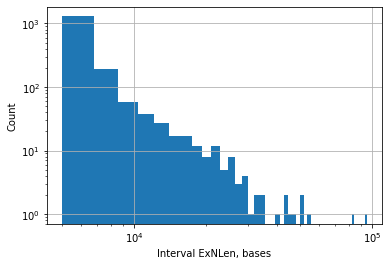

In [121]:
data_intervals = []
threads = 24
human_genome = iterate_over_records("../data/external/GCF_000001405.40/ncbi_dataset/data/GCF_000001405.40/")
with Pool(threads) as p:
    pre_data_intervals = p.map(partial(extract_intervals_from_one_record, cutpos=cutpos), human_genome)

data_intervals = []
for xx in pre_data_intervals:
    for x in xx:
        data_intervals.append(x)

intervals = pd.DataFrame(data_intervals)
intervals["Nshare"] = (intervals.Ncount / intervals.Lenght).fillna(0)
intervals["ExNLen"] = (intervals.Lenght - intervals.Ncount).fillna(0)

intervals[(intervals.ExNLen > 5000)].sort_values("Lenght")
print(intervals.shape[0], intervals[(intervals.ExNLen > 5000)].shape[0])
intervals[(intervals.ExNLen > 5000)].ExNLen.hist(bins=50)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Interval ExNLen, bases")
plt.ylabel("Count")
plt.show()

Nuclear genome cutted to 7.1 millions of intervals and only 1708 intervals have length > 5kb. Distribution of intervals lenghts are above

### Set of enzymes that we have or may to buy in sibenzyme + ClaI (14 enzymes)

In [7]:
cutpos_available = cutpos[(cutpos.RE.isin(sibenzyme.RE)) | (cutpos.RE == "ClaI")]
print(cutpos_available.RE.nunique(), cutpos_available.shape)

14 (2226107, 3)


In [15]:
sibenzyme[sibenzyme.RE.isin(cutpos_available.RE)]

,RE,ID,Site,Packaging,Variant
1,AbsI,E535_,CC↑TCGAGG / GGAGCT↓CC,1000 е.а. 200 е.а.,Regular
22,ArsI,E575,↑(N)8GACNNNNNNTTYG(N)11↑ / ↓(N)13CTGNNNNNNAARC...,250 е.а. 50 е.а.,Regular
24,AsiSI,E159,GCGAT↑CGC / CGC↓TAGCG,1000 е.а. 200 е.а.,Regular
49,BsePI,E181,G↑CGCGC / CGCGC↓G,1000 е.а. 200 е.а.,Regular
99,DraIII,E309,CACNNN↑GTG / GTG↓NNNCAC,2500 е.а. 500 е.а.,Regular
136,MluI,E085,A↑CGCGT / TGCGC↓A,1000 е.а. 5000 е.а.,Regular Turbo
145,NruI,E099,TCG↑CGA / AGC↓GCT,2500 е.а. 500 е.а.,Regular
146,PalAI,E483,GG↑CGCGCC / CCGCGC↓GG,1000 е.а. 200 е.а.,Regular
151,Ple19I,E195,CGAT↑CG / GC↓TAGC,100 е.а. 500 е.а.,Regular
162,PspXI,E477,VC↑TCGAGB / BGAGCT↓CV,1000 е.а. 200 е.а.,Concentrated Regular


In [8]:
cutpos_available

,Record,Pos,RE
318,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16052929,MluI
319,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16057794,MluI
320,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16168247,MluI
321,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",17438501,MluI
322,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",18708244,MluI
...,...,...,...
7108647,NT_113948.1 Homo sapiens chromosome 5 unlocali...,77470,ArsI
7108648,NT_113948.1 Homo sapiens chromosome 5 unlocali...,79652,ArsI
7108649,NT_113948.1 Homo sapiens chromosome 5 unlocali...,79684,ArsI
7108650,NT_113948.1 Homo sapiens chromosome 5 unlocali...,81865,ArsI


2226298 98999


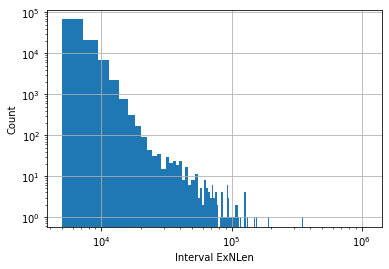

In [120]:
data_intervals = []
threads = 24
human_genome = iterate_over_records("../data/external/GCF_000001405.40/ncbi_dataset/data/GCF_000001405.40/")
with Pool(threads) as p:
    pre_data_intervals = p.map(partial(extract_intervals_from_one_record, cutpos=cutpos_available), human_genome)

data_intervals = []
for xx in pre_data_intervals:
    for x in xx:
        data_intervals.append(x)

intervals = pd.DataFrame(data_intervals)
intervals["Nshare"] = (intervals.Ncount / intervals.Lenght).fillna(0)
intervals["ExNLen"] = (intervals.Lenght - intervals.Ncount).fillna(0)

intervals[(intervals.ExNLen > 5000)].sort_values("Lenght")
print(intervals.shape[0], intervals[(intervals.ExNLen > 5000)].shape[0])
intervals[(intervals.ExNLen > 5000)].ExNLen.hist(bins=500)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Interval ExNLen")
plt.ylabel("Count")
plt.show()

Nuclear genome cutted to 2.2 millions of intervals and 98999 intervals have length > 5kb. Distribution of intervals lenghts are above.

Plot of all intervals lens and table with some basic statistics are below

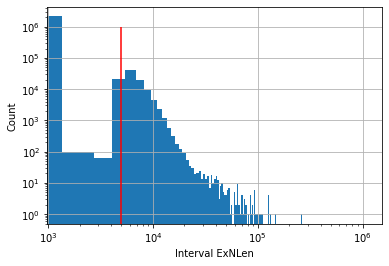

In [119]:
intervals.ExNLen.hist(bins=800)
plt.vlines([5000], 0, 10**6, "r")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Interval ExNLen")
plt.ylabel("Count")
plt.show()

In [116]:
intervals[(intervals.ExNLen > 5000)]["Lenght	Ncount	ExNLen".split()].describe().round(2)

,Lenght,Ncount,ExNLen
count,98999.00,98999.00,98999.00
mean,7794.07,677.20,7116.87
std,121233.31,121031.68,5570.86
min,5001.00,0.00,5001.00
25%,5554.00,0.00,5554.00
50%,6316.00,0.00,6316.00
75%,7671.00,0.00,7669.00
max,30020363.00,30000000.00,1092088.00


In [123]:
# Sum of intervals lens
intervals[(intervals.ExNLen > 5000)].ExNLen.sum()

12395499.0

### Set of used and available enzymes

In [107]:
i = 0
with open("../data/processed/used_re_isoschizomers_99.5%.txt") as fin:
    for line in fin:
        for enz in cutpos_available.RE.unique():
            if enz in line:
                i += 1
                print(i, line.strip())
                continue

1 MluI
2 XmaI,Cfr9I,SmaI,TspMI
3 BsePI,BssHII,McaTI,PauI,PteI
4 NruI,Bsp68I,BtuMI,RruI
5 PalAI,AscI,SgsI
6 PspXI
7 AbsI
8 AsiSI,RgaI,SfaAI,SgfI
9 SfiI
10 DraIII,AdeI
11 ArsI
12 SmiI,SwaI
13 Ple19I,PvuI
14 ClaI,Bsa29I,BseCI,BshVI,BspDI,Bsu15I,BsuTUI


## Stuff

In [54]:
record

SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN'), id='NC_000014.9', name='NC_000014.9', description='NC_000014.9 Homo sapiens chromosome 14, GRCh38.p14 Primary Assembly', dbxrefs=[])

In [49]:
ana = Analysis(maximal_subset, record.seq)

In [50]:
data = []
for enzyme, positions in ana.with_sites().items():
    for pos in positions:
        data.append({"RE": repr(enzyme), "Pos": pos})
cutpos = pd.DataFrame(data).sort_values("Pos")
cutpos.reset_index(drop=True, inplace=True)
cutpos.to_csv("../data/interim/Chr1_cutpos.csv", index=None)
cutpos

,RE,Pos
0,AcvI,16000812
1,DraIII,16000815
2,Ecl35734I,16001785
3,ArsI,16003465
4,ArsI,16003497
...,...,...
213518,PteI,106883553
213519,BoxI,106883621
213520,AspJHL3II,106883656
213521,UbaF13I,106883659


In [51]:
cutpos = pd.read_csv("../data/interim/Chr1_cutpos.csv")
cutpos

,RE,Pos
0,AcvI,16000812
1,DraIII,16000815
2,Ecl35734I,16001785
3,ArsI,16003465
4,ArsI,16003497
...,...,...
213518,PteI,106883553
213519,BoxI,106883621
213520,AspJHL3II,106883656
213521,UbaF13I,106883659


In [67]:
data = []
intervals = []
beg = 0
prev_RE = None
for i, row in cutpos.iterrows():
    end = row.Pos
    interval = seq_str[beg: end]
    if len(interval) > 5000:
        Ncount = interval.count("N") if "N" in interval else 0
    else:
        Ncount = None
    data.append({
        "Record": record.description,
        "Begin": beg,
        "End": end,
        "REbegin": prev_RE,
        "REend": row.RE,
        "Lenght": end - beg,
        "Ncount": Ncount,
    })
    beg = end
    prev_RE = row.RE

end = len(record)
interval = seq_str[beg: end]
if len(interval) > 5000:
    Ncount = interval.count("N") if "N" in interval else 0
else:
    Ncount = None
data.append({
    "Record": record.description,
    "Begin": beg,
    "End": end,
    "REbegin": prev_RE,
    "REend": None,
    "Lenght": end - beg,
    "Ncount": Ncount,
})

df = pd.DataFrame(data)

In [69]:
df.sort_values("Lenght", ascending=False).head(30)

,Record,Begin,End,REbegin,REend,Lenght,Ncount
0,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",0,16000812,None,AcvI,16000812,16000000.0
213523,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",106883687,107043718,MreI,None,160031,160000.0
3215,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",18712272,18862751,SmiI,Ecl35734I,150479,150000.0
4976,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",19511251,19611786,Cfr9I,BspGI,100535,100000.0
2358,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",18172920,18224875,Ecl35734I,UbaF13I,51955,50000.0
185,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16102253,16117148,BspGI,ArsI,14895,7856.0
25707,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",29124968,29133460,SmiI,BspGI,8492,0.0
161,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16068801,16077232,DraIII,SstE37I,8431,0.0
179,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16085223,16092685,ArsI,Ecl35734I,7462,2937.0
143299,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",83193477,83200664,Cfr9I,BspGI,7187,0.0


In [ ]:
# for fp in glob.glob("../data/external/GCF_000001405.40/ncbi_dataset/data/GCF_000001405.40/*.fna"):
#     if "chrMT" in fp:
#         continue
    
#     for record in SeqIO.parse(fp, format="fasta"):
#         for partof_chr in re.split("N{50,}", record):
#             if "mt" in partof_chr.description.lower():
#                 continue
#             ana = Analysis(maximal_subset, partof_chr.seq)
#             for enzyme, positions in ana.with_sites().items():
#                 # use values to sort and write to table
#                 # after that analize table and create subset
#                 pass
            

#         break